## Identificación de la serie de tiempo

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [19]:
ROOT = Path.cwd().resolve().parent
DATA = ROOT / "Data" / "train.csv"

In [ ]:
df = pd.read_csv(DATA)

In [21]:
df

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
...,...,...
2933,1993-06-30,69.6
2934,1993-07-31,80.4
2935,1993-08-31,62.5
2936,1993-09-30,31.2


Ahora procederemos a determinar si la serie es estacionaria (débil o fuerte) o no lo es. 

Los pasos a realizar son los siguientes:

### a) Realizar la gráfica de la serie.

### b) Determinar estacionariedad por medio de:
1. Test de Dickey–Fuller.
2. Correlograma de errores.

### c) En caso de no ser estacionaria, diferenciar.

### d) Realizar la gráfica de la serie diferenciada y regresar al punto **1a**.  En caso de ser estacionaria, continuar con **1e**.

### e) Estimar los órdenes **p** y **q** mediante el correlograma.


### a) Realizar la gráfica de la serie

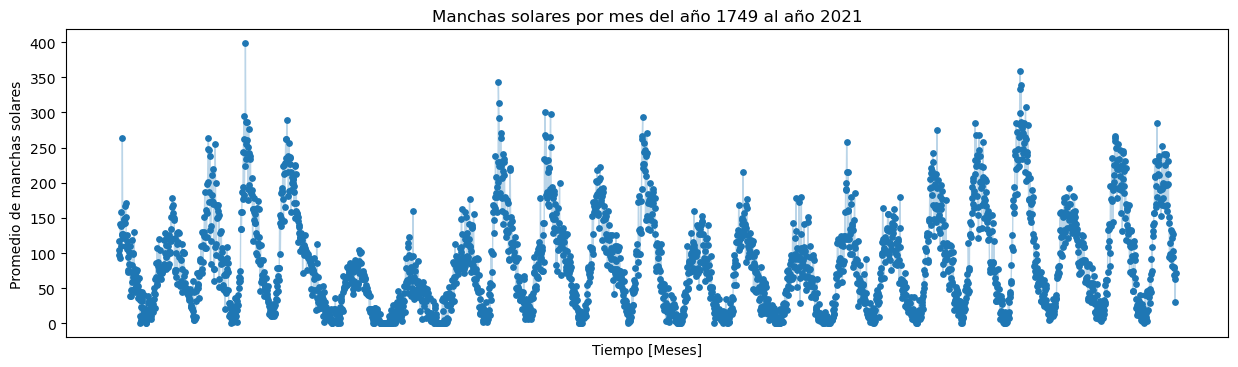

In [22]:
plt.figure(figsize=(15,4))
plt.plot(df['Date'], df['Monthly Mean Total Sunspot Number'],
         linestyle='-', alpha=0.3, linewidth=1)
plt.scatter(df['Date'], df['Monthly Mean Total Sunspot Number'],
            s=15)
plt.xticks([])
plt.title('Manchas solares por mes del año 1749 al año 2021')
plt.xlabel('Tiempo [Meses]')
plt.ylabel('Promedio de manchas solares')
plt.show()

### b) Determinar estacionariedad por medio de:
1. Test de Dickey–Fuller.
2. Correlograma de errores.

#### Test de Dickey-Fuller

In [23]:
def test_Dickey_Fuller():
    pass

#### Correlograma de errores

In [24]:
def correlograma_errores():
    pass